In [1]:
import sys
from copy import copy
from datetime import datetime, timedelta
from dateutil import tz
from uuid import UUID

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
msdf = pd.read_pickle("NiSb2O6_icpms_data.pickle")
ecdf = pd.read_pickle("NiSb2O6_eche_data.pickle")
indf = pd.read_pickle("NiSb2O6_inject_data.pickle")

In [3]:
els = ['Ni', 'Sb']
MASSD = {'Ni': 58.6934, 'Sb': 121.76}

# stacked plots

In [4]:
icpms_columns = [f"{k}_ppb" for k in els]
seqs = ecdf.drop_duplicates("sequence_uuid").sequence_uuid

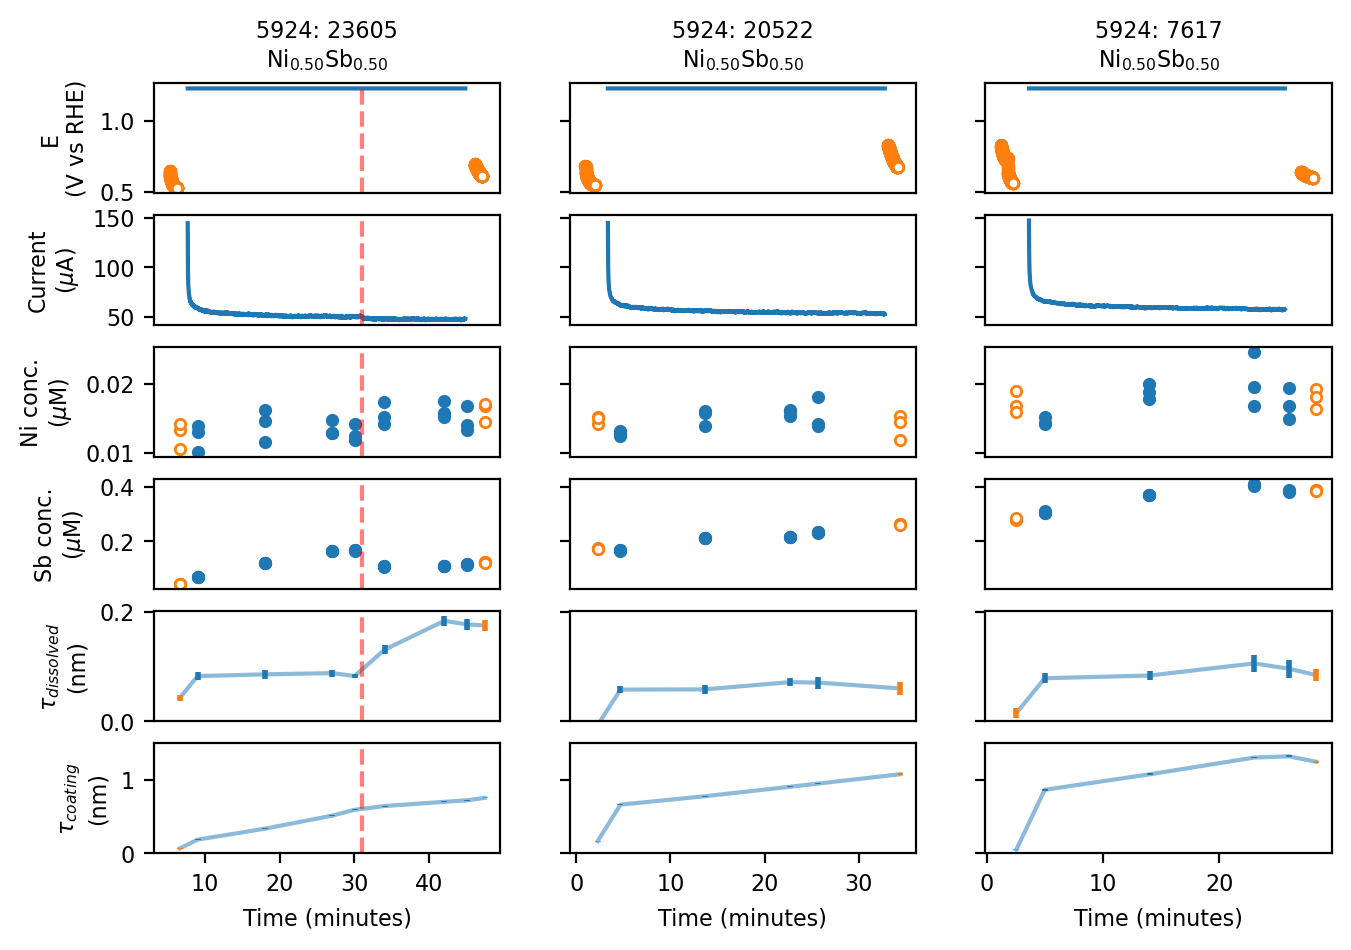

In [5]:
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10
SCATTER_SIZE = 14

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(
    4 + len(icpms_columns),
    len(seqs),
    sharey="row",
    sharex="col",
    figsize=(7.6, 5),
    dpi=200,
)

for i, suuid in enumerate(seqs):
    seche = ecdf.query("sequence_uuid == @suuid")
    compstr = "".join(
        [
            f"{k}$_" + "{" + f"{v:.2f}" + "}$"
            for k, v in sorted(seche.iloc[0].composition.items())
        ]
    )
    plate_id = seche.iloc[0].plate_id
    sample_no = seche.iloc[0].sample_no
    spal = msdf.query("sequence_uuid == @suuid")
    # row 0: potential vs time
    for _, carow in seche.query("action_name=='run_CA'").iterrows():
        times = [
            (
                datetime.fromtimestamp(carow.action_epoch, tz=tz.gettz("UTC"))
                + timedelta(seconds=t)
                - carow.sequence_timestamp.tz_localize("UTC")
            ).seconds
            / 60
            for t in carow.t_s
        ]
        ax[0, i].plot(times, carow.Erhe_V)
    for _, ocvrow in seche.query("action_name=='run_OCV'").iterrows():
        times = [
            (
                datetime.fromtimestamp(ocvrow.action_epoch, tz=tz.gettz("UTC"))
                + timedelta(seconds=t)
                - ocvrow.sequence_timestamp.tz_localize("UTC")
            ).seconds
            / 60
            for t in ocvrow.t_s
        ]
        ax[0, i].scatter(
            times,
            ocvrow.Erhe_V,
            facecolor="w",
            edgecolor=mpl.cm.tab10(1),
            s=SCATTER_SIZE,
        )
    # row 1: current vs time
    for _, carow in seche.query("action_name=='run_CA'").iterrows():
        times = [
            (
                datetime.fromtimestamp(carow.action_epoch, tz=tz.gettz("UTC"))
                + timedelta(seconds=t)
                - carow.sequence_timestamp.tz_localize("UTC")
            ).seconds
            / 60
            for t in carow.t_s
        ]
        ax[1, i].plot(times, np.array(carow.I_A) * 1e6)
        # ax[1, i].set_yscale("log")
    # remaining rows: icpms ppb
    for j, col in enumerate(els):
        moles = {"CA": [], "OCV": []}
        times = {"CA": [], "OCV": []}

        for _, msrow in spal.iterrows():
            for ppbval in msrow[f"{col}_ppb"]:
                cell_ml = msrow.cell_volume_ul * 1e-3
                aliquot_ml = msrow.aliquot_volume_ul * 1e-3
                moles_in_cell = cell_ml * 1e-3 * ppbval * 1e-6 / MASSD[col]
                # molarity = ppbval * 1e-6 / MASSD[col]
                molarity = ppbval / MASSD[col]  # micromolar
                pkey = "CA" if "CA" in msrow.experiment_name else "OCV"
                moles[pkey].append(molarity)
                times[pkey].append(
                    (
                        datetime.fromtimestamp(
                            msrow.aliquot_epoch, tz=tz.gettz("Pacific / Los Angeles")
                        ).replace(tzinfo=tz.gettz("UTC"))
                        - msrow.sequence_timestamp.tz_localize("UTC")
                    ).seconds
                    / 60
                )

        ax[2 + j, i].scatter(
            times["OCV"],
            moles["OCV"],
            facecolor="w",
            edgecolor=mpl.cm.tab10(1),
            s=SCATTER_SIZE,
        )
        ax[2 + j, i].scatter(
            times["CA"], moles["CA"], facecolor=mpl.cm.tab10(0), s=SCATTER_SIZE
        )
        if i == 0:
            ax[2 + j, i].set_ylabel(f"{col} conc.\n($\mu$M)")
    ocv_icpms = spal.query("experiment_name.str.contains('OCV')")
    ca_icpms = spal.query("experiment_name.str.contains('CA')")

    sns.lineplot(
        spal,
        x="aliquot_elapsed_min",
        y="NiSb2O6_dissolved_nm",
        ax=ax[len(els) + 2, i],
        alpha=0.5,
    )
    ax[len(els) + 2, i].errorbar(
        ocv_icpms.aliquot_elapsed_min,
        ocv_icpms.NiSb2O6_dissolved_nm,
        yerr=ocv_icpms.NiSb2O6_dissolved_nm_stdev,
        ecolor=mpl.cm.tab10(1),
        zorder=9,
        lw=0,
        elinewidth=2,
    )
    ax[len(els) + 2, i].errorbar(
        ca_icpms.aliquot_elapsed_min,
        ca_icpms.NiSb2O6_dissolved_nm,
        yerr=ca_icpms.NiSb2O6_dissolved_nm_stdev,
        ecolor=mpl.cm.tab10(0),
        lw=0,
        elinewidth=2,
    )

    sns.lineplot(
        spal,
        x="aliquot_elapsed_min",
        y="NiOOH_coating_nm",
        ax=ax[len(els) + 3, i],
        alpha=0.5,
    )
    ax[len(els) + 3, i].errorbar(
        ocv_icpms.aliquot_elapsed_min,
        ocv_icpms.NiOOH_coating_nm,
        yerr=ocv_icpms.NiOOH_coating_nm_stdev,
        ecolor=mpl.cm.tab10(1),
        zorder=9,
        lw=0,
        elinewidth=2,
    )
    ax[len(els) + 3, i].errorbar(
        ca_icpms.aliquot_elapsed_min,
        ca_icpms.NiOOH_coating_nm,
        yerr=ca_icpms.NiOOH_coating_nm_stdev,
        ecolor=mpl.cm.tab10(0),
        lw=0,
        elinewidth=2,
    )

    ax[len(els) + 2, i].set_ylim(0, None)
    ax[len(els) + 3, i].set_ylim(0, 1.5)

    if i == 0:
        ax[0, i].set_ylabel("E\n(V vs RHE)")
        ax[1, i].set_ylabel("Current\n($\mu$A)")
        ax[len(els) + 2, i].set_ylabel("$\\tau_{dissolved}$\n(nm)")
        ax[len(els) + 3, i].set_ylabel("$\\tau_{coating}$\n(nm)")
    for ri in range(3 + len(els)):
        ax[ri, i].xaxis.set_visible(False)
    ax[0, i].set_title(f"{plate_id}: {sample_no}\n{compstr}")
    ax[len(els) + 3, i].set_xlabel("Time (minutes)")

    ssol = indf.query("sequence_uuid == @suuid")[["action_epoch"]]
    if ssol.shape[0] > 0:
        infuse_epoch = ssol.iloc[0].action_epoch
        for rowi in range(4 + len(icpms_columns)):
            ax[rowi, i].axvline(
                x=(
                    datetime.fromtimestamp(infuse_epoch, tz=tz.gettz("UTC"))
                    - carow.sequence_timestamp.tz_localize("UTC")
                ).seconds
                / 60,
                ls="--",
                c="red",
                alpha=0.5,
                label="inject",
            )
# fig.tight_layout()

plt.savefig("NiSb2O6.svg", facecolor="w")

In [6]:
injectdf = copy(
    indf[
        [
            "sequence_uuid",
            "sequence_timestamp",
            "action_timestamp",
            "action_epoch",
            "process_params",
        ]
    ]
)
injectdf["elapsed_time_min"] = injectdf.apply(
    lambda row: (
        datetime.fromtimestamp(row.action_epoch, tz=tz.gettz("UTC"))
        - row.sequence_timestamp.tz_localize("UTC")
    ).seconds
    / 60,
    axis=1,
)

In [7]:
figdf = copy(msdf.sort_values("action_timestamp"))
figtable = pd.DataFrame(
    {
        "action_timestamp": figdf.action_timestamp,
        "sequence_uuid": figdf.sequence_uuid,
        "sample_no": figdf.sample_no,
        "aliquot_time_min": figdf.aliquot_elapsed_min,
        "V_i": figdf.cell_volume_ul - figdf.aliquot_volume_ul,
        "Ni_uM": figdf.Ni_mol_L.apply(lambda x: [y*1e6 for y in x]),
        "Sb_uM": figdf.Sb_mol_L.apply(lambda x: [y*1e6 for y in x]),
        "m_A": figdf.Sb_mol_cumulative_total,
        "m_A_stdev": figdf.Sb_mol_cumulative_total_stdev,
        "m_B": figdf.Ni_mol_cumulative_total,
        "m_B_stdev": figdf.Ni_mol_cumulative_total_stdev,
        "tau_dissolved_nm": figdf.NiSb2O6_dissolved_nm,
        "tau_dissolved_nm_stdev": figdf.NiSb2O6_dissolved_nm_stdev,
        "tau_coating_nm": figdf.NiOOH_coating_nm,
        "tau_coating_nm_stdev": figdf.NiOOH_coating_nm_stdev,
    }
)

In [8]:
inject_rows = []

for suuid in seqs:
    sequence_inject_df = injectdf.query("sequence_uuid == @suuid")
    if sequence_inject_df.shape[0] > 0:
        sequence_inject_row = sequence_inject_df.iloc[0]
    else:
        continue
    subfig = figtable.query("sequence_uuid == @suuid")
    preinject_idx = subfig.index[
        (subfig.aliquot_time_min < sequence_inject_row.elapsed_time_min)
    ].max()
    preinject_vol = figtable.iloc[preinject_idx].V_i
    inject_rows.append(
        pd.DataFrame(
            {
                "sequence_uuid": suuid,
                "action_timestamp": sequence_inject_row.action_timestamp,
                "aliquot_time_min": sequence_inject_row.elapsed_time_min,
                "V_i": sequence_inject_row.process_params[
                    "insert_electrolyte_volume_ul"
                ]
                + preinject_vol,
            },
            index=[preinject_idx + 1],
        )
    )

inject_rows_df = pd.concat(inject_rows, axis=0)

In [9]:
with pd.option_context("display.max_colwidth", 100):
    print(
        pd.concat(
            (
                pd.DataFrame({"aliquot_time_min": 0, "V_i": 3000}, index=[0]),
                pd.concat(
                    (
                        figtable,
                        inject_rows_df,
                    ),
                    axis=0,
                ).sort_values("action_timestamp"),
            )
        ).reset_index(drop=True).drop(["action_timestamp", "sequence_uuid"], axis=1)
    )

    aliquot_time_min   V_i  sample_no  \
0           0.000000  3000        NaN   
1           6.610942  2900    23605.0   
2           9.020675  2800    23605.0   
3          18.036713  2700    23605.0   
4          27.030996  2600    23605.0   
5          30.039854  2500    23605.0   
6          30.983333  5000        NaN   
7          34.045613  4900    23605.0   
8          42.037113  4800    23605.0   
9          45.049979  4700    23605.0   
10         47.437629  4600    23605.0   
11          2.281867  4500    20522.0   
12          4.699233  4400    20522.0   
13         13.682942  4300    20522.0   
14         22.688933  4200    20522.0   
15         25.702750  4100    20522.0   
16         34.421698  4000    20522.0   
17          2.544133  3900     7617.0   
18          4.984667  3800     7617.0   
19         13.993450  3700     7617.0   
20         22.977002  3600     7617.0   
21         25.951536  3500     7617.0   
22         28.308736  3400     7617.0   

               